In [9]:
# -- Bibliotecas
# --------------
import sys, numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mpmath
sys.path.append('../')

# Ambiente
from env.SimpleMDP import SimpleMDP

from models.LinearUtility_RSVI import LinearUtility_RSVI
from models.QuadraticUtility_RSVI import QuadraticUtility_RSVI

# Utils
import rl_utils.NBPlotting as nbp
import rl_utils.NBManipulation as nbm
import rl_utils.NBEvaluations as nbe

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problema Simples - MDP

In [2]:
# Configurações do ambiente
states, actions = 1, 1
epsilon = 0.000001

s_mdp = SimpleMDP(num_states = states, 
                  num_actions = actions, 
                  _fixed_probability = 0.5, 
                  _float_probability = 0.1)

T = s_mdp.build_transition_probabilities()
C = {}
for a in range(0, actions):
    C[a] = a + 1
    
config_reduzida = False

# Configurações de processamento
run_neutral_vi = True
run_neutral_pi = True
run_EUF_RSVI = True
run_EUF_RSPI = True
run_PWL_RSVI = True

# Configurações dos modelos
discount_factor = 0.999

rini_p = 0.05
rend_p = 1
step_p = 0.05
range_x = np.arange(rini_p, rend_p, step_p)

## Linear - Polynomial Utility Function

In [3]:
LinearUF_RSVI = {}
    
# range_lambda = [np.round(-0.5 + 0.5*i/10, 2) for i in range(0, 20)] 
range_slope = [0.5]

for vl_slope in range_slope:
    print(f'Processando: Slope [{vl_slope}]', end='\r')
    LinearUF_RSVI[vl_slope] = \
        nbe.run_driving_license(s_mdp, T, C, actions, model=LinearUtility_RSVI, model_name='LinearUF_RSVI',
        vl_slope=vl_slope, epsilon=epsilon, _log=False)

display(LinearUF_RSVI.keys())

df_LinearUF_RSVI = nbm.build_dataframe_driver_license(LinearUF_RSVI)
display(df_LinearUF_RSVI)

..\services\ErrorMetrics.py:18: RuntimeWarning: invalid value encountered in double_scalars
  residual.append(abs((V1[i] - V2[i])/V2[i]))


dict_keys([0.5])

,0,sG
Policy 0.5,0,0


In [4]:
LinearUF_RSVI[0.5]._policy_value[0][0]

[0.5,
 0.75,
 0.875,
 0.9375,
 0.96875,
 0.984375,
 0.9921875,
 0.99609375,
 0.998046875,
 0.9990234375,
 0.99951171875,
 0.999755859375,
 0.9998779296875,
 0.99993896484375,
 0.999969482421875,
 0.9999847412109375,
 0.9999923706054688,
 0.9999961853027344,
 0.9999980926513672,
 0.9999990463256836]

## Quadratic - Polynomial Utility Function

In [5]:
QuadraticUF_RSVI = {}
    
# range_lambda = [np.round(-0.5 + 0.5*i/10, 2) for i in range(0, 20)] 
range_slope1 = [0.5]
range_slope2 = [0.5]

for vl_slope1 in range_slope1:
    for vl_slope2 in range_slope2:
        print(f'Processando: Slope1 [{vl_slope1}] | Slope2 [{vl_slope2}]', end='\r')
        QuadraticUF_RSVI[(vl_slope1, vl_slope2)] = \
            nbe.run_driving_license(s_mdp, T, C, actions, model=QuadraticUtility_RSVI, model_name='QuadraticUF_RSVI',
            vl_slope1=vl_slope1, vl_slope2=vl_slope2, epsilon=epsilon, _log=False)

display(QuadraticUF_RSVI.keys())

df_QuadraticUF_RSVI = nbm.build_dataframe_driver_license(QuadraticUF_RSVI)
display(df_QuadraticUF_RSVI)

..\services\ErrorMetrics.py:18: RuntimeWarning: invalid value encountered in double_scalars
  residual.append(abs((V1[i] - V2[i])/V2[i]))


dict_keys([(0.5, 0.5)])

,0,sG
"Policy (0.5, 0.5)",0,0


In [6]:
QuadraticUF_RSVI[(0.5, 0.5)]._policy_value[0][0]

[1.0,
 1.5,
 1.75,
 1.875,
 1.9375,
 1.96875,
 1.984375,
 1.9921875,
 1.99609375,
 1.998046875,
 1.9990234375,
 1.99951171875,
 1.999755859375,
 1.9998779296875,
 1.99993896484375,
 1.999969482421875,
 1.9999847412109375,
 1.9999923706054688,
 1.9999961853027344,
 1.9999980926513672]

# Quadratic Utility Function

In [15]:
def _polynomial_sum_prob_converge(p, beta, th):
    error, sum_prob = np.inf, 0
    t = 1
    while (error > th) or (t < 1000):
        sum_prob_ant = sum_prob
        sum_prob += t**beta * (1 - p)**(t-1)
        
        error = sum_prob - sum_prob_ant
        t += 1
        
        #print(f'[{t}] Error: [{error}]', end='\r')
        
    return sum_prob

def polynomial_function(c, p, beta, th=0.1, _log=False):
    sum_prob = _polynomial_sum_prob_converge(p, beta, th)
        
    return c**beta * p * sum_prob

def _cost_polynomial_function(c, p, p_line, beta, th=0.1, _log=False):
    sum_prob_p = _polynomial_sum_prob_converge(p, beta, th)
    sum_prob_pline = _polynomial_sum_prob_converge(p_line, beta, th)
    
    value = (c**beta * p * sum_prob_p) / (p_line * sum_prob_pline)
    
    if _log: 
        print(f"""
          Cost PF - p: {p} | 
          c: {c} | 
          p\': {p_line} | 
          Numerador: {round((c**beta * p * sum_prob_p), 2)} | 
          Denominador: {round((p_line * sum_prob_pline), 2)} | 
          Value: {round(value, 2)} | 
          C\': {round(np.power(value, 1/beta), 2)}""")
    
    return np.round(np.power(value, 1/beta), 4)

def value_function_quf(p, c, beta=2):
    if beta == 1:
        return 1
    elif beta == 1:
        return (c/p)
    elif beta == 2:
        return (c**beta * (2 - p)) / (p**beta)
    elif beta == 3:
        return (c**beta * (p**2 - 6*p + 6)) / (p**beta)

def _func_beta_10(p):
    return -p**9 + 1022*p**8 - 55980*p**7 + 818520*p**6 - 5103000*p**5 + 16435440*p**4 - \
        29635200*p**3 + 30240000*p**2 - 16329600*p + 3628800

def _func_beta_20(p):
    return (-p**19 + 1048574*p**18 - 3483638676*p**17 + 1085570781624*p**16 - 89904730860000*p**15 + \
                   3100376804676480*p**14 - 56163512390086080*p**13 + 611692004959217280*p**12 - 4358654246117808000*p**11 + \
                   21473732319740064000*p**10 - 75875547089306764800*p**9 + 196877625020902425600*p**8 - \
                   380275818414395904000*p**7 + 549443323130397696000*p**6 - 591499300737945600000*p**5 + \
                   467644314338353152000*p**4 - 263665755136143360000*p**3 + 100357207837286400000*p**2 - \
                   23112569077678080000*p + 2432902008176640000)
    
def quf(p, c, p_line, beta=2):
    if beta == 0:
        return 1
    elif beta == 0.1:
        v = (np.power(c, beta) * p * mpmath.polylog((1-p), -beta) * (1 - p_line)) / ((1 - p) * p_line * mpmath.polylog((1-p_line), -beta))
        return np.power(v, 1/beta)
    elif beta == 1:
        return c * p_line / p #(c * (1 - p) * p_line) / (p * (1 - p_line))
    elif beta == 2:
        return np.sqrt((c**2 * p_line**2 * (2 - p)) / (p**2 * (2 - p_line)))
    elif beta == 3:
        eq_p = (p**2 - 6*p + 6)
        eq_p_line = (p_line**2 - 6*p_line + 6)
        v = (c**3 * eq_p * p_line**3) / (p**3 * eq_p_line)
        return np.power(v, 1/beta)
    elif beta == 10:
        v = (c**beta * p_line**beta * _func_beta_10(p)) / (p**beta * _func_beta_10(p_line))
        return np.power(v, 1/beta)
    elif beta == 20:
        v = (c**beta * p_line**beta * _func_beta_20(p)) / (p**beta * _func_beta_20(p_line))
        return np.power(v, 1/beta)

def captura_limite_empirico_quf(range_beta, p, c, p_line, tipo_limite, _plot=False):
    res = {}
    
    for beta in range_beta:
        res[round(beta, 2)] = quf(p, c, p_line, beta)
        
    if _plot: plt.plot(res.keys(), [v[1] for v in res.items()])
        
    aproximacao_limite = res[next(iter(res))] if tipo_limite == 'Inferior' else res[next(reversed(res))]
    return res, aproximacao_limite

def get_cost_limit_polynomial_utility_function(c, p, beta, _log=False):

    res_vetor_puf = {}
    res_quf = {}

    _sanidade_puf = {}

    for p_line in range_x:
        _sanidade_puf[round(p_line, 2)] = _cost_polynomial_function(c, p, p_line, beta, th=0.0001, _log=False)

        p_line = round(p_line, 2)
        res_vetor_puf[p_line], res_quf[p_line] = \
            captura_limite_empirico_quf([beta], p, c, p_line, tipo_limite='Inferior')

        if _log: print(f'Limite [Inferior] para p=[{p_line}] tende a: {np.round(res_quf[p_line], 2)}')

    if _log: print()
    if _log: print(_sanidade_puf)
    
    return _sanidade_puf, res_vetor_puf, res_quf

In [20]:
p, c = 0.5, 1
_sanidade_quf_01, limite_inferior_vetor_quf_01, limite_inferior_quf_01 = \
    get_cost_limit_polynomial_utility_function(c, p, 0.1)

_sanidade_quf_1, limite_inferior_vetor_quf_1, limite_inferior_quf_1 = \
    get_cost_limit_polynomial_utility_function(c, p, 1)

_sanidade_quf_2, limite_inferior_vetor_quf_2, limite_inferior_quf_2 = \
    get_cost_limit_polynomial_utility_function(c, p, 2)

_sanidade_quf_3, limite_superior_vetor_quf_3, limite_superior_quf_3 = \
    get_cost_limit_polynomial_utility_function(c, p, 3)

_sanidade_quf_10, limite_superior_vetor_quf_10, limite_superior_quf_10 = \
    get_cost_limit_polynomial_utility_function(c, p, 10)

_sanidade_quf_20, limite_superior_vetor_quf_20, limite_superior_quf_20 = \
    get_cost_limit_polynomial_utility_function(c, p, 20)

## Matplotlib

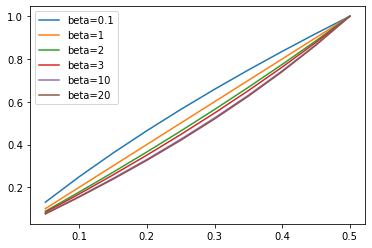

In [23]:
# plt.plot(range_x, limite_inferior_quf_0.values(), label="beta=0")
plt.plot(range_x[:10], [v for v in _sanidade_quf_01.values() if v <= 1], label="beta=0.1") 
plt.plot(range_x[:10], [v for v in limite_inferior_quf_1.values() if v <= 1], label="beta=1") 
plt.plot(range_x[:10], [v for v in limite_inferior_quf_2.values() if v <= 1], label="beta=2") 
plt.plot(range_x[:10], [v for v in limite_superior_quf_3.values() if v <= 1], label="beta=3") 
plt.plot(range_x[:10], [v for v in limite_superior_quf_10.values() if v <= 1], label="beta=10")
plt.plot(range_x[:10], [v for v in limite_superior_quf_20.values() if v <= 1], label="beta=20") 

plt.legend(loc="upper left")

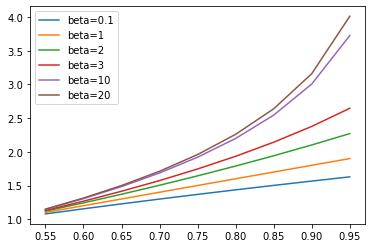

In [24]:
# plt.plot(range_x, limite_inferior_quf_0.values(), label="beta=0")
plt.plot(range_x[10:], [v for v in _sanidade_quf_01.values() if v > 1], label="beta=0.1") 
plt.plot(range_x[10:], [v for v in limite_inferior_quf_1.values() if v > 1], label="beta=1") 
plt.plot(range_x[10:], [v for v in limite_inferior_quf_2.values() if v > 1], label="beta=2") 
plt.plot(range_x[10:], [v for v in limite_superior_quf_3.values() if v > 1], label="beta=3") 
plt.plot(range_x[10:], [v for v in limite_superior_quf_10.values() if v > 1], label="beta=10") 
plt.plot(range_x[10:], [v for v in limite_superior_quf_20.values() if v > 1], label="beta=20")

plt.legend(loc="upper left")

## Plotly

In [25]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=range_x, y=list(_sanidade_quf_01.values()), mode='lines', name='beta=0.01'))
fig.add_trace(go.Scatter(x=range_x, y=list(limite_inferior_quf_1.values()), mode='lines', name='beta=1'))
fig.add_trace(go.Scatter(x=range_x, y=list(limite_inferior_quf_2.values()), mode='lines', name='beta=2'))
fig.add_trace(go.Scatter(x=range_x, y=list(limite_superior_quf_3.values()), mode='lines', name='beta=3'))
fig.add_trace(go.Scatter(x=range_x, y=list(limite_superior_quf_10.values()), mode='lines', name='beta=10'))
fig.add_trace(go.Scatter(x=range_x, y=list(limite_superior_quf_20.values()), mode='lines', name='beta=20'))

fig.update_layout(title="Polynomial Utility Function - V(c, p, beta) = V(c\', p\', beta)",
                   xaxis_title="p\'",
                   yaxis_title="c\'")
fig.update_layout(showlegend=True)
fig.show()

## Multiplos p\'

In [43]:
multi_sanidade_puf_01, multi_sanidade_puf_20 = {}, {}
multi_limite_vetor_puf_01, multi_limite_vetor_puf_20 = {}, {}
multi_limite_puf_01, multi_limite_puf_20 = {}, {}
c = 1

for p in np.arange(0.1, 1, 0.1):
    print(f'Processando p: [{p}]...', end='\r')
    multi_limite_vetor_puf_01[p], multi_limite_vetor_puf_20[p] = {}, {}
    multi_limite_puf_01[p], multi_limite_puf_20[p] = {}, {}
    multi_sanidade_puf_01[p], multi_sanidade_puf_20[p] = {}, {}
    
    multi_sanidade_puf_01[p], multi_limite_vetor_puf_01[p], multi_limite_vetor_puf_01[p] = \
        get_cost_limit_polynomial_utility_function(c, p, 0.1)
    multi_sanidade_puf_20[p], multi_limite_vetor_puf_20[p], multi_limite_vetor_puf_20[p] = \
        get_cost_limit_polynomial_utility_function(c, p, 20)

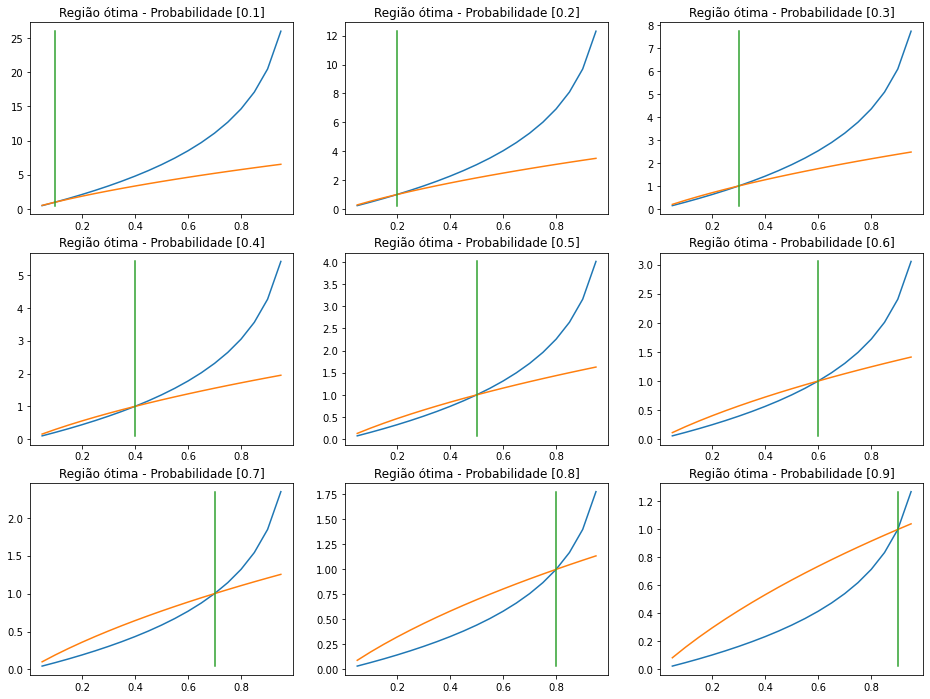

In [44]:
fig, axs = plt.subplots(3, 3, figsize=(16,12))
count1, count2 = 0, 0

for p in multi_limite_vetor_puf_1.keys():
    fig = axs[count1, count2].plot(range_x, multi_limite_vetor_puf_20[p].values())
    fig = axs[count1, count2].plot(range_x, multi_sanidade_puf_1[p].values()) 
    fig = axs[count1, count2].plot([p for v in multi_limite_vetor_puf_20[p].items()], multi_limite_vetor_puf_20[p].values())
    fig = axs[count1, count2].set_title(f'Região ótima - Probabilidade [{np.round(p, 1)}]')
    
    count2 += 1
    if count2 == 3:
        count2 = 0
        count1 += 1